In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTEN
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report
from sklearn.metrics import plot_det_curve
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
recipe_df = pd.read_csv('../../dataset/recipes.csv')
recipe_with_ingred = pd.read_csv('../../dataset/recipe_with_ingredient.csv')
food_df = pd.read_csv('../../dataset/food.csv')
ingred_spices_df = pd.read_csv('collect_spices_ingred_df.csv')

In [150]:
ingred_spices_df.head()

,Unnamed: 0,food_id,count,food_name
0,262,33908,995,Salt
1,317,33892,854,Black Pepper
2,334,36383,751,Garlic
3,218,34212,630,Olive Oil
4,390,33872,254,Cinnamon


# Feature Engineering
<hr />

#### Define label and merge with feature vectors

In [151]:
# Define labels
def mg_apply_func(row):
    fat, carb, protein = row['fat'] * 9, row['carbohydrate'] * 4, row['protein'] * 4
    total = row['calories']
    if total <= 0:
        return 0
    f_percent, c_percent, p_percent = fat / total, carb / total, protein / total
    if p_percent >= 0.35:
        if  0.15 <= f_percent <= 0.3:
            return 1
    return 0

In [152]:
recipe_df['fl_mg'] = recipe_df.apply(mg_apply_func, axis=1)

In [153]:
res_recipe_df = pd.merge(recipe_with_ingred, recipe_df[['recipe_id', 'fl_mg']], on='recipe_id', how='inner')

In [154]:
res_recipe_df.head()

,recipe_id,33919,39699,61271,3419,15845548,75372,570035,1071192,41011,...,1350,72158,49809,2200644,50123,40637,28033,38403,40592,fl_mg
0,45430986,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,42818205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42384638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42288128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8629075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop spices & seasoning

In [155]:
res_recipe_df = res_recipe_df.drop(labels = [str(x) for x in ingred_spices_df.food_id.values], axis = 1)
res_recipe_df.head()

,recipe_id,39699,61271,3419,15845548,75372,570035,1071192,41011,39128,...,1350,72158,49809,2200644,50123,40637,28033,38403,40592,fl_mg
0,45430986,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,42818205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42384638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,42288128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8629075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Feature selection with undersampling

In [156]:
def undersampleNegative(df, label, coef=1, random_state=0):
    positive_label_df = df[df[label] == 1]
    negative_label_df = df[df[label] == 0]
    negative_undersampled = negative_label_df.sample(n= round(coef * len(positive_label_df)), random_state=random_state)
    return pd.concat([positive_label_df, negative_undersampled ], axis= 0)

def tryFeaturePercent(df,params):
    best_accracy, best_percent = 0, 0
    for p in params:
        temp_df = df.loc[:, df.sum(axis=0)/df.shape[0] >= p]
        X, y = df.iloc[:, 1:df.shape[1] - 1], df.iloc[:, df.shape[1] - 1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
        rf = RandomForestClassifier() 
        rf = rf.fit(X_train, y_train)
        cur_acc = accuracy_score(y_test, rf.predict(X_test))
        if cur_acc >= best_accracy:
            best_percent = p
            best_accracy = cur_acc
    return best_percent, best_accracy

def tryDiffRandomState(params):
    best_params = []
    for p in params:
        feature_select_df = undersampleNegative(res_recipe_df, 'fl_mg', 1, p)
        cur_best_percent, cur_best_acc  = tryFeaturePercent(feature_select_df, np.linspace(0.0004, 0.005, 40))
        best_params.append(cur_best_percent)
    return best_params

def viewIngredient(df):
    to_int_lst = []
    for i in df.columns[1: res_recipe_df.shape[1] - 1]:
        to_int_lst.append(int(i))
    return food_df[food_df['food_id'].isin(to_int_lst)]

In [157]:
# find params to cut rare features
# This cell takes about 3 min to run (deppeding on the size of iterable passed in)

params = tryDiffRandomState(range(0,10))
print(f'The pramas in each iteration to select features are {params}')

The pramas in each iteration to select features are [0.004882051282051283, 0.004528205128205128, 0.004646153846153847, 0.0026410256410256414, 0.004882051282051283, 0.0011076923076923078, 0.002287179487179487, 0.0019333333333333333, 0.004882051282051283, 0.0014615384615384616]


In [158]:
optimal_params = np.mean(params)
optimal_params 

0.003325128205128205

In [159]:
# elliminate rare ingredient

res_recipe_df = res_recipe_df.loc[:, res_recipe_df.sum(axis=0)/res_recipe_df.shape[0] >= optimal_params]
print(f'The size of dataframe after selection {res_recipe_df.shape}')

The size of dataframe after selection (3365, 249)


In [160]:
# drop row if it does not contain any ingredient

res_recipe_df = res_recipe_df.loc[(res_recipe_df.iloc[:, 1:res_recipe_df.shape[1] - 1] != 0).any(axis=1)]
print(f'The size of dataframe after drop rows with no ingredient {res_recipe_df.shape}')

The size of dataframe after drop rows with no ingredient (3214, 249)


In [205]:
# drop duplicates

res_recipe_df = res_recipe_df[res_recipe_df.iloc[:, 1:res_recipe_df.shape[1] - 1].duplicated() == False]
print(f'The size of dataframe after drop rows with duplicates {res_recipe_df.shape}')

The size of dataframe after drop rows with duplicates (2841, 249)


# UnderSampling
<hr />

In [162]:
def splitDataset(df, test_size=0.2, random_state=0):
    X, y = df.iloc[:, 1:df.shape[1] - 1], df.iloc[:, df.shape[1] - 1]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)
    

In [163]:
# undersampleNegative(df, 'label to undersample', 'coef', 'random state')
final_df = undersampleNegative(res_recipe_df, 'fl_mg', 1, 0)

In [164]:
X_train, X_test, y_train, y_test = splitDataset(final_df)
print(f"class counts in traning set: {Counter(y_train)}")

class counts in traning set: Counter({0: 189, 1: 182})


# Model Building and Training
<hr />

In [167]:
def printAccruacy(model_name, actual_test, predictions_test, actual_train=None, predictions_train=None):
    print(f'The accuracy of {model_name} is: {accuracy_score(actual_test, predictions_test)}')
    if actual_train is not None and predictions_train is not None:
        print(f'The accuracy of {model_name} on training set is: {accuracy_score(actual_train, predictions_train)}')
    
def printCVscore(model, X_train, y_train, cv=10):
    score = np.mean(cross_validate(model, X_train, y_train, cv=cv)['test_score'])
    print(f'The mean CV score using {cv}-fold coross validation is: {score}')
    return score

### Logistic regression

In [170]:
param_grid = {'C' : np.linspace(0.01, 3, 100)}
lg_grid_search = GridSearchCV(LogisticRegression(),param_grid = param_grid, cv = 10, n_jobs=-1)
lg_grid_search.fit(X_train, y_train)
lg_grid_search.best_params_

{'C': 0.7650505050505052}

In [173]:
lg_model = LogisticRegression(C=0.765)
lg_model.fit(X_train, y_train)
lg_Predicts = lg_model.predict(X_test)
printAccruacy('lg model', y_test, lg_Predicts, y_train, lg_model.predict(X_train))
score = printCVscore(lg_model, X_train, y_train, 10)

The accuracy of lg model is: 0.7204301075268817
The accuracy of lg model on training set is: 0.8571428571428571
The mean CV score using 10-fold coross validation is: 0.6660028449502133


### Rondom Forest and Pruning

In [174]:
# print number of features in original dataset
print('# of features:',final_df.shape[1])

# of features: 249


In [175]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['sqrt', 'log2']

# Criterion to split on
rf_criterion = ['gini', 'entropy']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]


# # Method of selecting samples for training each tree
# rf_bootstrap = [True, False]


rf_min_samples_leaf = [1, 2, 4]
# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_leaf': rf_min_samples_leaf,
               'min_samples_split': rf_min_samples_split,
               }
rf_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['sqrt', 'log2'],
 'criterion': ['gini', 'entropy'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [176]:
# Create the model to be tuned
rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, scoring='f1',
                               n_iter = 500, cv = 5, verbose = True, random_state = 2, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# View the best parameters from the random search
rf_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'n_estimators': 400,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'criterion': 'entropy'}

In [177]:
rf_model = RandomForestClassifier(n_estimators=400, 
                                            min_samples_split=6,
                                            min_samples_leaf=1,
                                            max_features='log2',
                                            max_depth=20,
                                            criterion='entropy'
                                        ) 
# n_estimators=400, 
# min_samples_split=5,
# min_impurity_decrease=0.0,
# max_features='log2',
# max_depth=15,
# criterion='entropy',
# bootstrap=True
rf_model = rf_model.fit(X_train, y_train)
rf_Predicts = rf_model.predict(X_test)

In [178]:
printAccruacy('random forest', y_test, rf_Predicts, y_train, rf_model.predict(X_train))
socre = printCVscore(rf_model, X_train, y_train, 10)

The accuracy of random forest is: 0.7204301075268817
The accuracy of random forest on training set is: 0.889487870619946
The mean CV score using 10-fold coross validation is: 0.6549786628733998


### SVM and Tunning

In [179]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

In [180]:
gamma_range

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [194]:
Cs = np.linspace(1, 2, 100)
svc_grid = {'C': Cs}

svc_grid_search = GridSearchCV(SVC(kernel='rbf'), svc_grid, cv=10, n_jobs = -1, verbose = 2)
svc_grid_search.fit(X_train, y_train)
svc_grid_search.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'C': 1.7272727272727273}

In [196]:
svc_model = SVC(C=1.72727)
svc_model.fit(X_train, y_train)
svc_Predicts = svc_model.predict(X_test)
printAccruacy('SVC model', y_test, svc_Predicts, y_train, svc_model.predict(X_train))
socre = printCVscore(svc_model, X_train, y_train)

The accuracy of SVC model is: 0.7311827956989247
The accuracy of SVC model on training set is: 0.9568733153638814
The mean CV score using 10-fold coross validation is: 0.6524893314367


### Bernoulli Naive Bayes

In [200]:
params = {'alpha': np.linspace(0.1, 0.5, 100)
         }

bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
bernoulli_nb_grid.fit(X_train,y_train)
bernoulli_nb_grid.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'alpha': 0.297979797979798}

In [201]:
nb_model = BernoulliNB(alpha=0.29797979)
nb_model.fit(X_train, y_train)
nb_Predicts = nb_model.predict(X_test)
printAccruacy('NB model', y_test, nb_Predicts, y_train, nb_model.predict(X_train))
score = printCVscore(nb_model, X_train, y_train)

The accuracy of NB model is: 0.7526881720430108
The accuracy of NB model on training set is: 0.8194070080862533
The mean CV score using 10-fold coross validation is: 0.6605263157894737


# Model Evaluation
<hr />

### Percison, recall, f1-socre, accuracy

In [202]:
def printReport(model_name, actual_test, predictions_test):
    print(f'For {model_name}:')
    print('-----------------------------------------------------')
    print(classification_report(actual_test, predictions_test, digits=4))

In [203]:
# evaluate lg_model, rf_model，svc_model, nb_model
printReport('logisitc Regression', y_test, lg_Predicts)
printReport('Random Forest', y_test, rf_Predicts)
printReport('SVC', y_test, svc_Predicts)
printReport('Naive Bayes', y_test, nb_Predicts)

For logisitc Regression:
-----------------------------------------------------
              precision    recall  f1-score   support

           0     0.6809    0.7442    0.7111        43
           1     0.7609    0.7000    0.7292        50

    accuracy                         0.7204        93
   macro avg     0.7209    0.7221    0.7201        93
weighted avg     0.7239    0.7204    0.7208        93

For Random Forest:
-----------------------------------------------------
              precision    recall  f1-score   support

           0     0.6809    0.7442    0.7111        43
           1     0.7609    0.7000    0.7292        50

    accuracy                         0.7204        93
   macro avg     0.7209    0.7221    0.7201        93
weighted avg     0.7239    0.7204    0.7208        93

For SVC:
-----------------------------------------------------
              precision    recall  f1-score   support

           0     0.7045    0.7209    0.7126        43
           1     0.755

### ROC and AUC

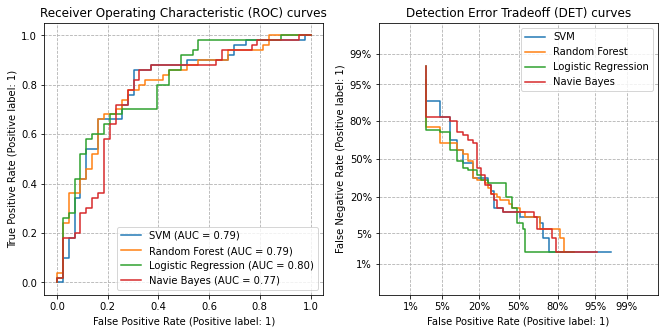

In [204]:
N_SAMPLES = 1000

classifiers = {
    "SVM": svc_model,
    "Random Forest": rf_model,
    "Logistic Regression": lg_model,
    "Navie Bayes": nb_model
}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name=name)
    plot_det_curve(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_det.set_title('Detection Error Tradeoff (DET) curves')

ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')

plt.legend()
plt.show()

## Pickle Models

In [211]:
models = {'lg_model': lg_model, 'rf_model': rf_model, 'svc_model': svc_model, 'nb_model': nb_model}
info = {'df': final_df, 'models': models}

with open("./fl_mg_final_info.pickle","wb") as f:
    pickle.dump(info, f)